# Project 5

TO DO

1) échantillon: diff population, proportion de protein animal, dispo alim proteins\habitant, dispo alim calories\habitant AND your own variables +++
2) Dendrogramm of countries, cut it to get 5 groups. +++
3) Point out characteristics of each group by 4 main variables (Q1). +++ Calculate centroids for each group +++
4) Short list of countries to make exports to. +++
5) Visualize groups in 1st factorial plane of PCA +++
6) Make sure groups are really different via statistical test: a goodness-of-fit, comparison of 2 populations. +++

In [1]:
# import libraries

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy

%matplotlib inline

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing, decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering

from scipy.stats import ks_2samp
from scipy import stats

from geopy import distance

In [2]:
# mise en place du dossier de travail
# setting up working directory

os.chdir(r"C:\Users\aciag\Desktop\IDF OpenClassrooms\P5_Mykhailytskyi_Mykola")
print("Current working directory is " + os.getcwd())

from functions import * # OC custom funcs, can be replaced with manual code
from functions2 import * # OC custom funcs, can be replaced with manual code

Current working directory is C:\Users\aciag\Desktop\IDF OpenClassrooms\P5_Mykhailytskyi_Mykola


In [3]:
### PANDAS SETTINGS
# change the format of floats from scientific into more readable
pd.options.display.float_format = '{:,.2f}'.format

### data

In [4]:
# import csv files into Pandas dataframes

# ALL DATA TAKEN FROM FAO BULK DOWNLOAD (DONNEES COMPLET) https://www.fao.org/faostat/en/#home

population = pd.read_csv('data/Faostat/Population_E_All_Data_(Normalized).csv')

food_security = pd.read_csv('data/Faostat/Food_Security_Data_E_All_Data_(Normalized).csv')

food_balance = pd.read_csv('data/Faostat/FoodBalanceSheets_E_All_Data_(Normalized).csv')

crops_livestock = pd.read_csv('data/Faostat/SUA_Crops_Livestock_E_All_Data_(Normalized).csv')

prices = pd.read_csv('data/Faostat/Prices_E_All_Data_(Normalized).csv')

production_crops_livestock = pd.read_csv('data/Faostat/Production_Crops_Livestock_E_All_Data_(Normalized).csv')

trade_crops_livestock = pd.read_csv('data/Faostat/Trade_Crops_Livestock_E_All_Data_(Normalized).csv')

In [5]:
# population

exclusion_list = [512, 513, 551, 561]
population = population[~population['Element Code'].isin(exclusion_list)]

In [6]:
# exclude regions from the data, leaving only Countries

exlusion_list2 = ['World', 'Africa', 'Eastern Africa', 'Middle Africa',
                  'Northern Africa', 'Southern Africa', 'Western Africa',
                  'Americas', 'Northern America', 'Central America', 'Caribbean',
                  'South America', 'Asia', 'Central Asia', 'Eastern Asia',
                  'Southern Asia', 'South-Eastern Asia', 'Western Asia', 'Europe',
                  'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe',
                  'Oceania', 'Australia and New Zealand', 'Melanesia', 'Micronesia', 'Polynesia',
                  'European Union', 'Least Developed Countries', 'Land Locked Developing Countries',
                  'Small Island Developing States', 'Low Income Food Deficit Countries','Net Food Importing Developing Countries']

population = population[~population['Area'].isin(exlusion_list2)]

In [7]:
# exclude data for years we dont need

exlusion_list3 = [2015, 2020]

population = population[population['Year'].isin(exlusion_list3)]

In [8]:
worldPop = population.query("Year == 2020").sum() * 1000
print("World population according to 2020 stats is " + str(worldPop.Value) + " humans.")

World population according to 2020 stats is 9266367341.000002 humans.


In [9]:
# exclude dupes of China data

exclusion_list4 = [96, 128, 41, 214]

population = population[~population['Area Code'].isin(exclusion_list4)]

In [10]:
worldPop = population.query("Year == 2020").sum() * 1000
print("World population according to 2020 stats is " + str(worldPop.Value) + " humans.")

World population according to 2020 stats is 7795080474.0 humans.


In [11]:
# calculate population change as %

pop2015 = population.query("Year == 2015")
pop2020 = population.query("Year == 2020")

pop2020['pop%change'] = -((pop2015.Value.values - pop2020.Value.values) / ((pop2015.Value.values + pop2020.Value.values) / 2)) * 100

pop2020.head(3)

<ipython-input-11-c399195c025e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop2020['pop%change'] = -((pop2015.Value.values - pop2020.Value.values) / ((pop2015.Value.values + pop2020.Value.values) / 2)) * 100


,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag,Note,pop%change
70,2,Afghanistan,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2020,2020,1000 persons,"38,928.35",X,NaN,12.31
725,3,Albania,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2020,2020,1000 persons,"2,877.80",X,NaN,-0.44
1380,4,Algeria,3010,Population - Est. & Proj.,511,Total Population - Both sexes,2020,2020,1000 persons,"43,851.04",X,NaN,9.87


In [12]:
# food security

food_security_list = ['Average protein supply (g/cap/day) (3-year average)',
                      'Average supply of protein of animal origin (g/cap/day) (3-year average)',
                      'Political stability and absence of violence/terrorism (index)',
                      'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)']

food_security = food_security[food_security['Item'].isin(food_security_list)]

exclusion_list5 = ['World', 'Africa', 'Eastern Africa',
       'Middle Africa', 'Northern Africa',
       'North Africa (excluding Sudan)', 'Southern Africa',
       'Western Africa', 'Sub-Saharan Africa',
       'Sub-Saharan Africa (including Sudan)',
       'Northern America and Europe', 'Northern America', 'Europe',
       'Eastern Europe', 'Northern Europe', 'Southern Europe',
       'Western Europe', 'Latin America and the Caribbean',
       'Central America', 'Caribbean', 'South America', 'Asia',
       'Central Asia', 'Eastern Asia', 'East Asia (excluding China)',
       'Southern Asia', 'South Asia (excluding India)',
       'South-eastern Asia', 'Western Asia',
       'Central Asia and Southern Asia',
       'Eastern Asia and South-eastern Asia',
       'Western Asia and Northern Africa', 'Oceania',
       'Australia and New Zealand', 'Melanesia', 'Micronesia',
       'Polynesia', 'Least Developed Countries',
       'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries', 'Low income economies',
       'Lower-middle-income economies', 'High-income economies',
       'Upper-middle-income economies']

food_security = food_security[~food_security['Area'].isin(exclusion_list5)]

food_security = food_security.drop(columns=['Note', 'Flag'])

food_security.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value
72,2,Afghanistan,21013,Average protein supply (g/cap/day) (3-year ave...,6123,Value,20002002,2000-2002,g/capita/day,51.4
73,2,Afghanistan,21013,Average protein supply (g/cap/day) (3-year ave...,6123,Value,20012003,2001-2003,g/capita/day,52.1
74,2,Afghanistan,21013,Average protein supply (g/cap/day) (3-year ave...,6123,Value,20022004,2002-2004,g/capita/day,54


In [13]:
polit_stab = food_security.loc[food_security['Item'] == 'Political stability and absence of violence/terrorism (index)']
polit_stab = polit_stab.loc[polit_stab['Year'] == '2019']
polit_stab.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value
253,2,Afghanistan,21032,Political stability and absence of violence/te...,6125,Value,2019,2019,index,-2.65


In [14]:
gdp = food_security.loc[food_security['Item'] == 'Gross domestic product per capita, PPP, dissemination (constant 2011 international $)']
gdp = gdp.loc[gdp['Year'] == '2019']
gdp.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value
123,2,Afghanistan,22013,"Gross domestic product per capita, PPP, dissem...",6126,Value,2019,2019,I$,2065


In [15]:
food_security['Value'] = pd.to_numeric(food_security['Value'])

In [16]:
food_security_calories = food_security.query("Year =='2019'")
food_security_protein = food_security.query("Year == '2016-2018'")

In [17]:
avg_protein = food_security_protein.loc[food_security_protein['Item Code'] == 21013]
avg_animal_protein = food_security_protein.loc[food_security_protein['Item Code'] == 21014]

In [18]:
proteins = avg_protein[['Area Code', 'Area', 'Item', 'Unit', 'Value']].merge(avg_animal_protein[['Area Code', 'Item', 'Value']], how='right', on='Area Code')

proteins['animal_protein_proportion'] = proteins['Value_y'] / proteins['Value_x']

proteins.rename(columns={'Value_x':'Avg_protein_supply_gcapday', 'Value_y':'Avg_animal_protein_supply_gcapday'}, inplace=True)

proteins.drop(columns=['Item_x', 'Item_y'], inplace=True)

proteins.head(3)

,Area Code,Area,Unit,Avg_protein_supply_gcapday,Avg_animal_protein_supply_gcapday,animal_protein_proportion
0,2,Afghanistan,g/capita/day,55.70,10.70,0.19
1,3,Albania,g/capita/day,116.70,62.70,0.54
2,4,Algeria,g/capita/day,92.30,25.60,0.28


In [19]:
# prices

chicken_prices = prices.loc[prices['Item'] == 'Meat, chicken', :]
chicken_prices = chicken_prices.loc[chicken_prices['Element'] == 'Producer Price (USD/tonne)', :]
chicken_prices = chicken_prices.loc[chicken_prices['Months'] == 'Annual value', :]
chicken_prices = chicken_prices.loc[chicken_prices['Year'] == 2019, :]

chicken_prices.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Months Code,Months,Unit,Value,Flag
26212,9,Argentina,1058,"Meat, chicken",5532,Producer Price (USD/tonne),2019,2019,7021,Annual value,USD,"1,155.40",NaN
34452,1,Armenia,1058,"Meat, chicken",5532,Producer Price (USD/tonne),2019,2019,7021,Annual value,USD,"5,184.50",NaN
53590,11,Austria,1058,"Meat, chicken",5532,Producer Price (USD/tonne),2019,2019,7021,Annual value,USD,"2,984.70",NaN


In [20]:
# food_balance

item_list = ['Grand Total', 'Animal Products']

food_balance = food_balance[food_balance['Item'].isin(item_list)]

area_list = ['World', 'Africa', 'Eastern Africa',
       'Middle Africa', 'Northern Africa', 'Southern Africa',
       'Western Africa', 'Americas', 'Northern America',
       'Central America', 'Caribbean', 'South America', 'Asia',
       'Central Asia', 'Eastern Asia', 'Southern Asia',
       'South-eastern Asia', 'Western Asia', 'Europe', 'Eastern Europe',
       'Northern Europe', 'Southern Europe', 'Western Europe', 'Oceania',
       'Australia and New Zealand', 'Melanesia', 'Micronesia',
       'Polynesia', 'European Union (28)', 'European Union (27)',
       'Least Developed Countries', 'Land Locked Developing Countries',
       'Small Island Developing States',
       'Low Income Food Deficit Countries',
       'Net Food Importing Developing Countries']

food_balance = food_balance[~food_balance['Area'].isin(area_list)]

food_balance = food_balance.loc[(food_balance['Year'] == 2018)]

food_balance['Value'] = pd.to_numeric(food_balance['Value'])

In [21]:
fb_food = food_balance.loc[(food_balance['Item'] == 'Grand Total') & (food_balance['Element'] == 'Food supply (kcal/capita/day)')]
fb_protein = food_balance.loc[(food_balance['Item'] == 'Grand Total') & (food_balance['Element'] == 'Protein supply quantity (g/capita/day)')]
fb_animal_protein = food_balance.loc[(food_balance['Item'] == 'Animal Products') & (food_balance['Element'] == 'Protein supply quantity (g/capita/day)')]

In [22]:
fb_anim_prot_prop = fb_protein[['Area Code', 'Area', 'Item', 'Unit', 'Value']].merge(fb_animal_protein[['Area Code', 'Item', 'Value']], how='right', on='Area Code')
fb_anim_prot_prop['anim_prot_prop'] = fb_anim_prot_prop['Value_y'] / fb_anim_prot_prop['Value_x']
fb_anim_prot_prop.loc[fb_anim_prot_prop['Item_x'] == 'Grand Total'].head(3)

,Area Code,Area,Item_x,Unit,Value_x,Item_y,Value_y,anim_prot_prop
0,2,Afghanistan,Grand Total,g/capita/day,55.52,Animal Products,10.79,0.19
1,3,Albania,Grand Total,g/capita/day,115.74,Animal Products,61.75,0.53
2,4,Algeria,Grand Total,g/capita/day,91.83,Animal Products,24.73,0.27


In [23]:
# crops_livestock

item_list = ['Meat, chicken']

crops_livestock = crops_livestock[crops_livestock['Item'].isin(item_list)]

In [24]:
# chicken export
chkn_export = crops_livestock.loc[(crops_livestock['Element'] == 'Export Quantity') & (crops_livestock['Year'] == 2017)]

# chicken import
chkn_import = crops_livestock.loc[(crops_livestock['Element'] == 'Import Quantity') & (crops_livestock['Year'] == 2017)]

# chicken production
chkn_production = crops_livestock.loc[(crops_livestock['Element'] == 'Production') & (crops_livestock['Year'] == 2017)]

In [25]:
# production_crops_livestock

item_list = ['Meat, chicken']

production_crops_livestock = production_crops_livestock[production_crops_livestock['Item'].isin(item_list)]

# chicken production2
chkn_production2 = production_crops_livestock.loc[(production_crops_livestock['Element'] == 'Production') & (production_crops_livestock['Year'] == 2019)]

In [26]:
# trade_crops_livestock

item_list = ['Meat, chicken']

area_list = ['China (excluding intra-trade)', 'World', 'Africa', 'Africa (excluding intra-trade)', 'Eastern Africa', 'Eastern Africa (excluding intra-trade)',
             'Middle Africa', 'Middle Africa (excluding intra-trade)', 'Northern Africa', 'Northern Africa (excluding intra-trade)', 'Southern Africa',
             'Southern Africa (excluding intra-trade)', 'Western Africa', 'Western Africa (excluding intra-trade)', 'Americas',
             'Americas (excluding intra-trade)', 'Northern America', 'Northern America (excluding intra-trade)', 'Central America',
       'Central America (excluding intra-trade)', 'Caribbean', 'Caribbean (excluding intra-trade)', 'South America', 'South America (excluding intra-trade)',
             'Asia', 'Asia (excluding intra-trade)', 'Central Asia', 'Central Asia (excluding intra-trade)', 'Eastern Asia', 'Eastern Asia (excluding intra-trade)',
             'Southern Asia', 'Southern Asia (excluding intra-trade)', 'South-eastern Asia', 'South-Eastern Asia (excluding intra-trade)', 'Western Asia',
       'Western Asia (excluding intra-trade)', 'Europe',
       'Europe (excluding intra-trade)', 'Eastern Europe',
       'Eastern Europe (excluding intra-trade)', 'Northern Europe',
       'Northern Europe (excluding intra-trade)', 'Southern Europe',
       'Southern Europe (excluding intra-trade)', 'Western Europe',
       'Western Europe (excluding intra-trade)', 'Oceania',
       'Oceania (excluding intra-trade)', 'Australia and New Zealand',
       'Australia and New Zealand (excluding intra-trade)', 'Melanesia',
       'Melanesia (excluding intra-trade)', 'Micronesia',
       'Micronesia (excluding intra-trade)', 'Polynesia',
       'Polynesia (excluding intra-trade)',
       'European Union (12) (excluding intra-trade)',
       'European Union (15) (excluding intra-trade)',
       'European Union (25) (excluding intra-trade)',
       'European Union (27) (excluding intra-trade)',
       'European Union (28)',
       'European Union (28) (excluding intra-trade)',
       'European Union (27)', 'Least Developed Countries',
       'Least Developed Countries (excluding intra-trade)',
       'Land Locked Developing Countries',
       'Land Locked Developing Countries (excluding intra-trade)',
       'Small Island Developing States',
       'Small Island Developing States (excluding intra-trade)',
       'Low Income Food Deficit Countries',
       'Low Income Food Deficit Countries (excluding intra-trade)',
       'Net Food Importing Developing Countries',
       'Net Food Importing Developing Countries (excluding intra-trade)']

trade_crops_livestock = trade_crops_livestock[trade_crops_livestock['Item'].isin(item_list)]
trade_crops_livestock = trade_crops_livestock[~trade_crops_livestock['Area'].isin(area_list)]

In [27]:
# chicken exports2
chkn_export2 = trade_crops_livestock.loc[(trade_crops_livestock['Element'] == 'Export Quantity') & (trade_crops_livestock['Year'] == 2018)]

# chicken imports2
chkn_import2 = trade_crops_livestock.loc[(trade_crops_livestock['Element'] == 'Import Quantity') & (trade_crops_livestock['Year'] == 2018)]

In [28]:
import_price = trade_crops_livestock.loc[(trade_crops_livestock['Element'] == 'Import Value') & (trade_crops_livestock['Year'] == 2019)].copy()
import_qtty = trade_crops_livestock.loc[(trade_crops_livestock['Element'] == 'Import Quantity') & (trade_crops_livestock['Year'] == 2019)].copy()

import_price['Value'] = pd.to_numeric(import_price['Value'])
import_qtty['Value'] = pd.to_numeric(import_qtty['Value'])

chkn_import_price = import_price[['Area Code', 'Area', 'Item', 'Element', 'Unit', 'Value']].merge(import_qtty[['Area Code', 'Item', 'Element', 'Value']], how='left', on='Area Code')
chkn_import_price['import_price_USD_tonne'] = (chkn_import_price['Value_x'] * 1000) / chkn_import_price['Value_y']
chkn_import_price.head(3)

,Area Code,Area,Item_x,Element_x,Unit,Value_x,Item_y,Element_y,Value_y,import_price_USD_tonne
0,2,Afghanistan,"Meat, chicken",Import Value,1000 US$,"57,624.00","Meat, chicken",Import Quantity,"42,874.00","1,344.03"
1,3,Albania,"Meat, chicken",Import Value,1000 US$,"62,156.00","Meat, chicken",Import Quantity,"46,025.00","1,350.48"
2,4,Algeria,"Meat, chicken",Import Value,1000 US$,0.00,"Meat, chicken",Import Quantity,0.00,NaN


## df_global

In [29]:
# start making single DF with all data we need for analysis

df_global = pop2015[['Area Code', 'Area', 'Unit','Value']].merge(pop2020[['Area Code', 'Value', 'pop%change']], how='left', on='Area Code')

df_global.rename(columns={'Value_x':'Pop_2015', 'Value_y':'Pop_2020'}, inplace=True)

df_global['Pop_2015'] = df_global['Pop_2015'] * 1000
df_global['Pop_2020'] = df_global['Pop_2020'] * 1000

df_global.drop(columns=['Unit'], inplace=True)

In [30]:
# animal protein proportion

df_global2 = df_global.merge(
    proteins[['Area Code', 'Avg_protein_supply_gcapday', 'Avg_animal_protein_supply_gcapday', 'animal_protein_proportion']],
    how='left', on='Area Code')

In [31]:
# political stability

df_global3 = df_global2.merge(polit_stab[['Area Code', 'Value']], how='left', on='Area Code')
df_global3 = df_global3.rename(columns={'Value':'polit_stab'})

In [32]:
#GDP

df_global4 = df_global3.merge(gdp[['Area Code', 'Value']], how='left', on='Area Code')
df_global4 = df_global4.rename(columns={'Value':'GDP_percapita_USD'})

In [33]:
# chicken prices (USD\tonne)

df_global5 = df_global4.merge(chicken_prices[['Area Code', 'Value']], how='left', on='Area Code')
df_global5 = df_global5.rename(columns={'Value':'ChknMeat_price_USD_tonne'})

In [34]:
# food supply (kcal\capita\day)

df_global6 = df_global5.merge(fb_food[['Area Code', 'Value']], how='left', on='Area Code')
df_global6 = df_global6.rename(columns={'Value':'food_supply_kcalcapday'})

In [35]:
# another PROTEIN (g\capita\day)

df_global7 = df_global6.merge(fb_protein[['Area Code', 'Value']], how='left', on='Area Code')
df_global7 = df_global7.rename(columns={'Value':'protein_supply_gcapday'})

In [36]:
# chicken production

df_global8 = df_global7.merge(chkn_production2[['Area Code', 'Value']], how='left', on='Area Code')
df_global8 = df_global8.rename(columns={'Value':'Chkn_production_tonnes'})

In [37]:
# import and export

df_global9 = df_global8.merge(chkn_import2[['Area Code', 'Value']], how='left', on='Area Code')
df_global9 = df_global9.rename(columns={'Value':'Chkn_import_tonnes'})

df_global10 = df_global9.merge(chkn_export2[['Area Code', 'Value']], how='left', on='Area Code')
df_global10 = df_global10.rename(columns={'Value':'Chkn_export_tonnes'})

In [38]:
# importation of chicken price

df_global11 = df_global10.merge(chkn_import_price[['Area Code', 'import_price_USD_tonne']], how='left', on='Area Code')

In [39]:
# reorder columns and delete dupe cols (population for 2015 and 2020)

df = df_global11[['Area Code', 'Area', 'pop%change', 'food_supply_kcalcapday', 'protein_supply_gcapday',
                  'animal_protein_proportion', 'Chkn_production_tonnes', 'Chkn_import_tonnes', 'Chkn_export_tonnes',
                  'ChknMeat_price_USD_tonne', 'import_price_USD_tonne','GDP_percapita_USD', 'polit_stab']].copy()

# convert dtypes
df['GDP_percapita_USD'] = pd.to_numeric(df['GDP_percapita_USD'])
df['polit_stab'] = pd.to_numeric(df['polit_stab'])

# convert daily averages to yearly
df['food_supply_kcalcapday'] = df['food_supply_kcalcapday'] * 365
df['protein_supply_gcapday'] = df['protein_supply_gcapday'] * 365

# rename cols according to new values and towards same formatting
df.rename(columns={'pop%change':'Pop%change', 'food_supply_kcalcapday':'Food_supply_kcalcapyear', 'protein_supply_gcapday':'Protein_supply_gcapyear',
                  'animal_protein_proportion':'Animal_protein_proportion', 'import_price_USD_tonne':'Import_price_USD_tonne', 'polit_stab':'Polit_stab'}, inplace=True)

df.head(3)

,Area Code,Area,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Chkn_export_tonnes,ChknMeat_price_USD_tonne,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab
0,2,Afghanistan,12.31,"744,600.00","20,264.80",0.19,"28,493.00","23,913.00",154.00,NaN,"1,344.03","2,065.00",-2.65
1,3,Albania,-0.44,"1,226,400.00","42,245.10",0.54,"11,633.00","11,588.00",NaN,NaN,"1,350.48","13,671.50",0.12
2,4,Algeria,9.87,"1,212,530.00","33,517.95",0.28,"264,081.00",27.00,380.00,NaN,NaN,"11,510.60",-1.00


In [40]:
# adding distance

df_dist = pd.read_csv("C:/Users/aciag/Desktop/IDF OpenClassrooms/P5_Mykhailytskyi_Mykola/concap.csv")
df_dist = df_dist.rename(columns={'CountryName':'Area', 'CapitalLatitude':'lat', 'CapitalLongitude':'lon'})
df_dist = df_dist.set_index('Area')
df_dist = df_dist.drop(columns=['CapitalName', 'CountryCode', 'ContinentName'])

fr1 = df_dist[df_dist.index == 'France'].loc[:, 'lat'][0]
fr2 = df_dist[df_dist.index == 'France'].loc[:, 'lon'][0]

for index, row in df_dist.iterrows():
    df_dist.loc[index, 'disttoFR_km'] = distance.distance((fr1, fr2), (row['lat'], row['lon'])).km

df = df.merge(df_dist[['disttoFR_km']], how='left', on='Area')

In [41]:
# amount of missing values, per column, in %
(df.isna().sum()/df.shape[0]*100).round(2)

Area Code                    0.00
Area                         0.00
Pop%change                   0.00
Food_supply_kcalcapyear     27.47
Protein_supply_gcapyear     27.47
Animal_protein_proportion   27.47
Chkn_production_tonnes      17.60
Chkn_import_tonnes          19.74
Chkn_export_tonnes          44.64
ChknMeat_price_USD_tonne    83.26
Import_price_USD_tonne      20.17
GDP_percapita_USD           20.60
Polit_stab                  16.74
disttoFR_km                 15.88
dtype: float64

In [42]:
# data cleaning

df = df.replace([np.inf, -np.inf], np.nan) # infs to nans
df = df.drop(columns=['Area Code', 'ChknMeat_price_USD_tonne', 'Chkn_export_tonnes']) # drop cols with a lot of missing data \ redundant
df = df.dropna() # drop rows with NaNs to have clearer analysis
df = df.set_index('Area') # set country name as index

In [43]:
# verify there is no missing data after cleaning
(df.isna().sum()/df.shape[0]*100).round(2)

Pop%change                  0.00
Food_supply_kcalcapyear     0.00
Protein_supply_gcapyear     0.00
Animal_protein_proportion   0.00
Chkn_production_tonnes      0.00
Chkn_import_tonnes          0.00
Import_price_USD_tonne      0.00
GDP_percapita_USD           0.00
Polit_stab                  0.00
disttoFR_km                 0.00
dtype: float64

## TASK 1 (echantillon \ sample)

In [44]:
print(df.shape)
df.head(5)

(136, 10)


,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km
Area,,,,,,,,,,
Afghanistan,12.31,"744,600.00","20,264.80",0.19,"28,493.00","23,913.00","1,344.03","2,065.00",-2.65,"5,596.67"
Albania,-0.44,"1,226,400.00","42,245.10",0.54,"11,633.00","11,588.00","1,350.48","13,671.50",0.12,"1,606.18"
Angola,16.40,"870,525.00","19,363.25",0.30,"49,034.00","322,678.00","1,047.10","6,670.30",-0.31,"6,479.98"
Antigua and Barbuda,4.56,"892,425.00","29,269.35",0.64,32.00,"5,944.00","1,938.10","21,548.70",0.96,"6,710.50"
Argentina,4.80,"1,207,055.00","38,971.05",0.64,"2,202,707.00","6,624.00","1,311.06","22,063.90",-0.12,"11,038.36"


## TASK 2 (Dendrogram with 5 clusters)

In [45]:
# loading data that we want to analyse
X = df.copy()

In [46]:
# standardizing the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# hierarchical clustering model
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True)

# fit data to the model and count countries in clusters
hiercluster.set_params(n_clusters=5)
clusters = hiercluster.fit_predict(X_scaled)
#print(np.bincount(clusters))

# add cluster number to original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

# size of clusters
print(X_scaled_clustered['cluster'].value_counts())

X_scaled_clustered.head(5)

1    61
0    36
2    30
4     8
3     1
Name: cluster, dtype: int64


,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km,cluster
Area,,,,,,,,,,,
Afghanistan,1.16,-1.90,-1.31,-1.47,-0.35,-0.32,-0.39,-0.94,-2.90,-0.01,2
Albania,-1.19,1.05,1.61,0.70,-0.36,-0.41,-0.38,-0.35,0.17,-1.06,0
Angola,1.91,-1.13,-1.43,-0.77,-0.33,1.86,-0.68,-0.70,-0.30,0.23,2
Antigua and Barbuda,-0.27,-1.00,-0.11,1.31,-0.37,-0.45,0.20,0.04,1.10,0.29,1
Argentina,-0.23,0.93,1.18,1.35,1.29,-0.45,-0.42,0.07,-0.09,1.44,1


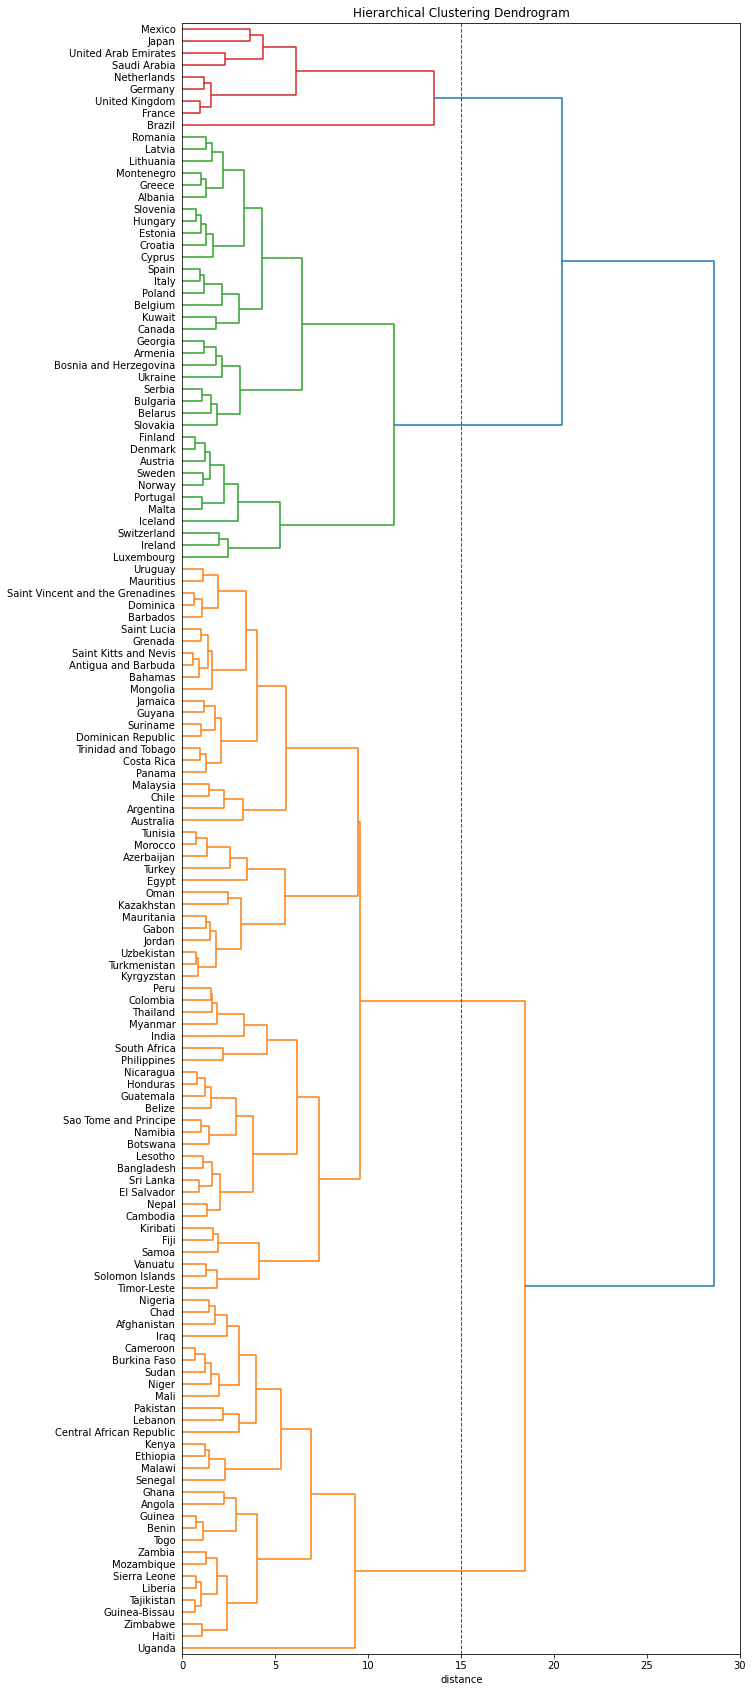

In [47]:
# show dendrogram of the clusters
sample = X_scaled_clustered
Z = linkage(sample, 'ward')
names = sample.index
# plot_dendrogram(Z, names)

plt.figure(figsize=(10,30))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('distance')
dendrogram(Z, labels = names, orientation = "right", leaf_font_size=10, color_threshold=20)

plt.axvline(x=15, c='red', lw=1, linestyle='dashed')

plt.savefig(fname='Hierarchical Clustering Dendrogram.jpg', dpi=100, format='jpg',
           orientation='vertical', bbox_inches='tight')
plt.show();

In [48]:
# visualize the clusters

# PCA model for dimensionality reduction
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

# transform scaled data into the new PCA space
X_reduced = pca.transform(X_scaled)

## TASK 5 (visualize clusters on first factorial plane)

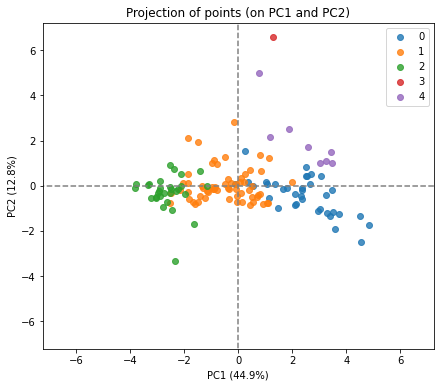

In [49]:
display_factorial_planes(X_reduced, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)

## TASK 3 (describe groups by sample vars)

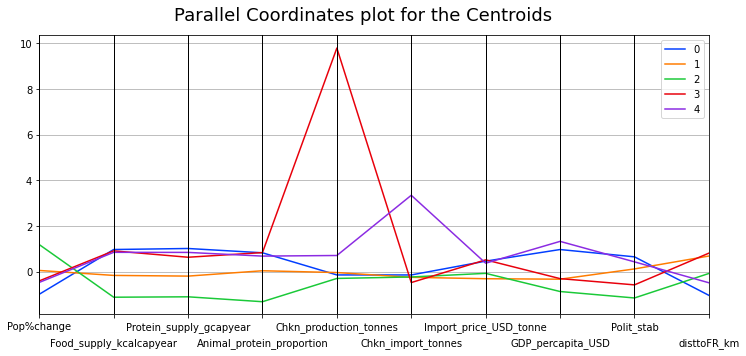

In [50]:
# interpretation of clusters

X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered['cluster'] = clusters

# cluster characteristics with parallel plot of means for each variable

means = X_clustered.groupby(by='cluster').mean()
display_parallel_coordinates_centroids(means.reset_index(), 5)

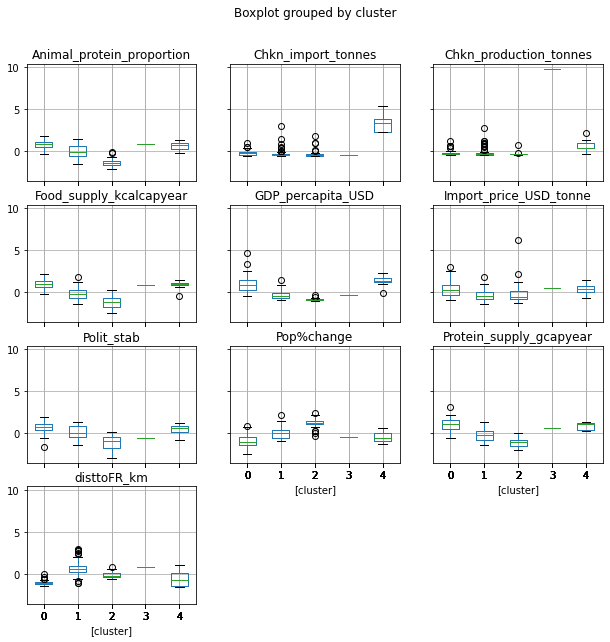

In [51]:
# cluster characteristics with boxplots

X_clustered.boxplot(by='cluster', figsize=(10,10))
plt.show();

In [52]:
# return clusters to original data

df_clustered = df.merge(X_scaled_clustered[['cluster']], how='left', on='Area')
df_clustered.groupby('cluster').mean()

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km
cluster,,,,,,,,,,
0,0.71,"1,214,578.06","37,802.85",0.56,"311,129.14","49,063.61","2,211.31","40,103.65",0.56,"1,740.29"
1,6.36,"1,029,521.39","28,714.49",0.43,"449,319.21","34,804.08","1,433.99","14,268.57",0.08,"8,231.50"
2,12.49,"873,712.67","21,901.22",0.22,"107,056.37","37,006.27","1,671.05","3,536.56",-1.07,"5,349.84"
3,3.88,"1,204,865.00","34,923.20",0.56,"13,516,525.00","3,396.00","2,267.99","14,763.90",-0.55,"8,706.47"
4,3.52,"1,194,462.50","36,514.60",0.54,"1,442,476.25","527,531.50","2,120.66","47,208.97",0.36,"3,816.50"


### Critique of 5 groups (dendrogram):
group 0 - high animal protein proportion (APP), average chkn production, high import, high import price, high gdp, highest polit stab. GOOD CHOICE

group 1 - high pop increase, min food supply and animal protein proportion, lowest prod of chkn, lowest gpd and polit stab. WORST CHOICE

group 2 - highest APP, highest chkn production volume, high gdp, negative plot stab. BAD CHOICE

group 3 - highest import of chkn, highest gdp, positive polit stab. GOOD CHOICE

group 4 - 2nd highest pop increase, 2nd lowest food supply, 2nd lowest animal protein proportion, 2nd lowest polit stab. WORST CHOICE

In [53]:
# separate two most probable clusters for our goal

cluster0 = df_clustered.loc[(df_clustered['cluster'] == 0)]
cluster3 = df_clustered.loc[(df_clustered['cluster'] == 3)]

cluster0.sort_values(by=['Chkn_import_tonnes'], ascending=False).head(10)

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km,cluster
Area,,,,,,,,,,,
Belgium,2.64,"1,375,685.00","36,452.55",0.59,"440,460.00","208,579.00","1,715.54","51,742.70",0.48,261.78,0
Kuwait,10.73,"1,266,915.00","37,671.65",0.48,"56,000.00","140,601.00","1,950.73","49,853.70",0.20,"4,412.66",0
Canada,4.65,"1,301,590.00","38,003.80",0.53,"1,328,368.00","138,100.00","2,030.27","49,006.70",1.03,"5,663.85",0
Ukraine,-2.68,"1,132,230.00","31,554.25",0.43,"1,381,400.00","121,750.00",978.97,"12,808.80",-1.52,"2,030.40",0
Spain,0.18,"1,212,530.00","39,255.75",0.62,"1,412,220.00","120,981.00","1,996.64","40,805.90",0.32,"1,054.23",0
Romania,-3.51,"1,307,065.00","39,872.60",0.50,"507,106.00","105,781.00","1,362.08","29,857.60",0.53,"1,876.31",0
Bulgaria,-3.55,"1,041,710.00","30,389.90",0.48,"88,970.00","96,874.00","1,103.65","23,191.60",0.54,"1,763.42",0
Ireland,5.95,"1,418,025.00","42,916.70",0.60,"141,000.00","74,719.00","3,841.59","87,786.20",0.97,777.09,0
Slovakia,0.44,"1,047,915.00","25,758.05",0.54,"70,100.00","73,736.00","1,830.50","31,871.30",0.78,"1,093.50",0


In [54]:
cluster3.sort_values(by=['Chkn_import_tonnes'], ascending=False).head(10)

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km,cluster
Area,,,,,,,,,,,
Brazil,3.88,"1,204,865.00","34,923.20",0.56,"13,516,525.00","3,396.00","2,267.99","14,763.90",-0.55,"8,706.47",3


In [55]:
# narrow down list of countries using our data

# better data to see which countries heavily rely on imports
country_selection = df_clustered.copy()
country_selection['prod_imp_proportion'] = country_selection['Chkn_import_tonnes'] / country_selection['Chkn_production_tonnes']
country_selection = country_selection.replace([np.inf, -np.inf], 0)
country_selection = country_selection.sort_values(by='prod_imp_proportion', ascending=False)

# remove countries with bad political stability, low animal protein proportion, and with dominant production and\or low imports
country_selection = country_selection.loc[(country_selection['Polit_stab'] >= 0) & (country_selection['Animal_protein_proportion'] >= 0.50) & (country_selection['prod_imp_proportion'] >= 1.50)]
# sort by richest countries among those
country_selection = country_selection.sort_values(by='GDP_percapita_USD', ascending=False)

In [56]:
country_selection

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km,cluster,prod_imp_proportion
Area,,,,,,,,,,,,
Luxembourg,9.93,"1,264,725.00","39,657.25",0.62,294.00,"7,816.00","4,745.64","113,940.00",1.36,287.32,0,26.59
Bahamas,4.96,"969,075.00","29,451.85",0.64,"6,206.00","19,536.00","1,988.17","37,100.40",0.83,"7,216.31",1,3.15
Antigua and Barbuda,4.56,"892,425.00","29,269.35",0.64,32.00,"5,944.00","1,938.10","21,548.70",0.96,"6,710.50",1,185.75
Montenegro,0.18,"1,277,500.00","41,803.45",0.61,"3,769.00","7,268.00","2,224.23","21,533.90",0.01,"1,496.48",0,1.93
Grenada,2.63,"876,730.00","26,031.80",0.56,415.00,"6,101.00","1,643.51","17,050.30",0.96,"7,118.86",1,14.70
Saint Lucia,2.48,"955,570.00","31,324.30",0.61,"1,429.00","3,544.00","1,320.26","15,448.30",0.93,"6,903.45",1,2.48
Saint Vincent and the Grenadines,1.63,"1,083,320.00","32,915.70",0.56,452.00,"7,219.00","1,389.40","12,484.70",0.96,"6,990.65",1,15.97
Mongolia,8.92,"941,335.00","31,868.15",0.65,192.00,"11,642.00","1,859.90","12,316.80",0.64,"7,069.08",1,60.64
Dominica,1.12,"1,077,480.00","28,864.20",0.57,362.00,"3,916.00","1,620.73","11,905.90",1.07,"6,825.58",1,10.82


## TASK 4 (list of countries to target)

In [57]:
# by import quantity
#cluster0: Belgium, Kuwait, Romania, Bulgaria, Czechia, Ireland
#cluster3: UAE, Germany, UK, Netherlands

# by production quantity
#cluster0: Saint Kitts and Nevis, Antigua and Barbuda, Mongolia, Luxembourg, Samoa
#cluster3: UAE, Germany, Netherlands, UK

# by excluding countries with low import\produce ratio, low animal protein use, bad polit stab, etc.
# 'Luxembourg', 'Bahamas', 'Antigua and Barbuda', 'Montenegro', 'Grenada', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Mongolia', 'Dominica', 'Samoa'

<AxesSubplot:>

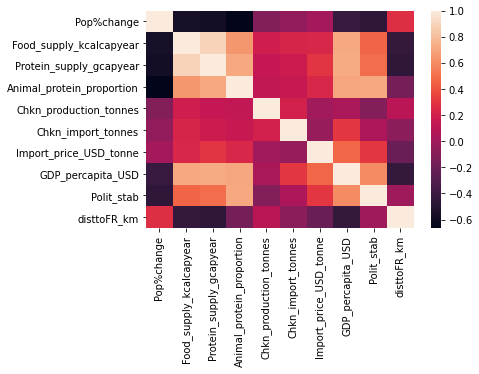

In [58]:
#sns.heatmap(df_clustered.groupby('cluster').corr())
sns.heatmap(df_clustered.iloc[:,:-1].corr())

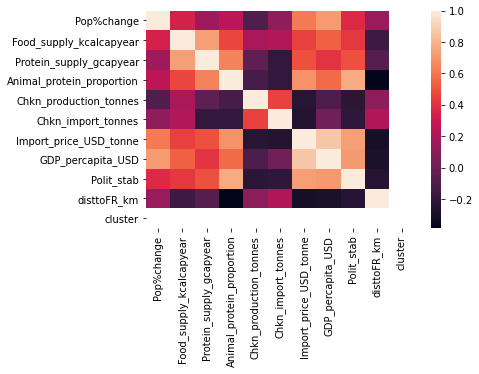

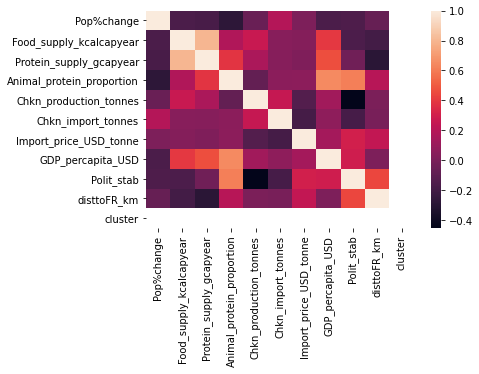

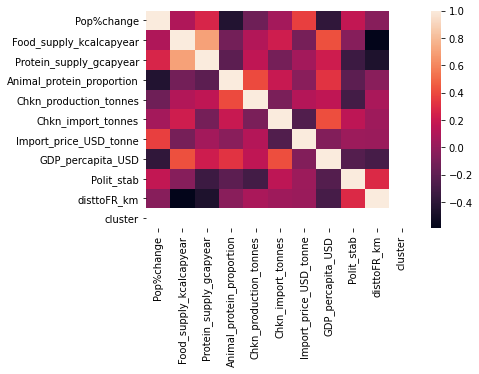

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\seaborn\matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\seaborn\matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


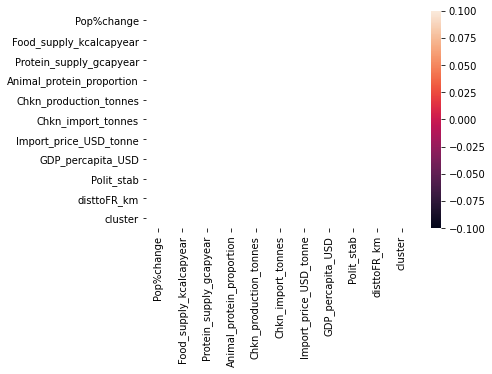

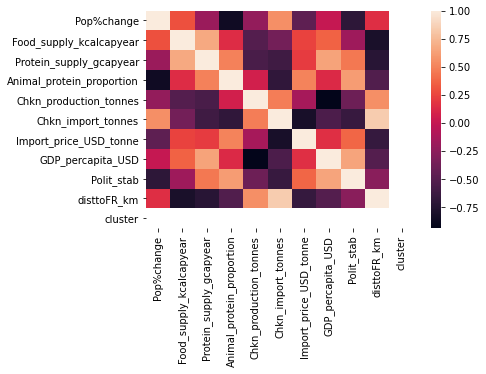

In [59]:
sns.heatmap(df_clustered.loc[df_clustered['cluster']==0].corr())
plt.show();
sns.heatmap(df_clustered.loc[df_clustered['cluster']==1].corr())
plt.show();
sns.heatmap(df_clustered.loc[df_clustered['cluster']==2].corr())
plt.show();
sns.heatmap(df_clustered.loc[df_clustered['cluster']==3].corr())
plt.show();
sns.heatmap(df_clustered.loc[df_clustered['cluster']==4].corr())
plt.show();

## PCA v2

In [60]:
# get data
X = df.copy()

# data standartization
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# select num of PC and do PCA
num_components = 5

pca = decomposition.PCA(n_components=num_components)

pca.fit(X_scaled)

PCA(n_components=5)

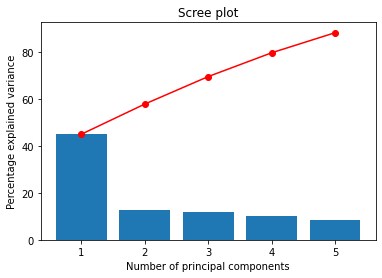

[0.44906372 0.57729829 0.69412875 0.79523062 0.88063056]


In [61]:
# scree plot for variance vs PC
display_scree_plot(pca)

print(pca.explained_variance_ratio_.cumsum())

In [62]:
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]
pc4 = pca.components_[3]
pc5 = pca.components_[4] 

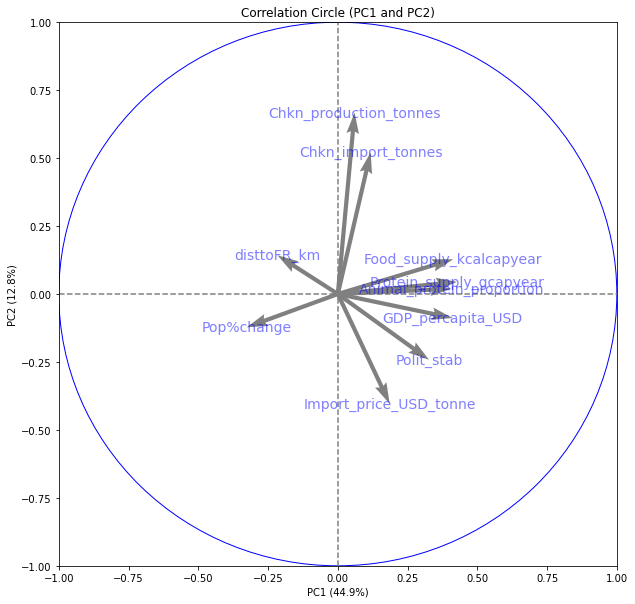

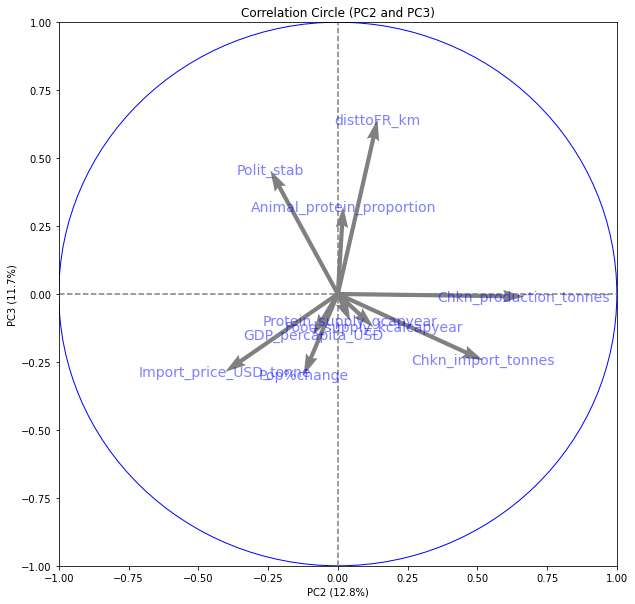

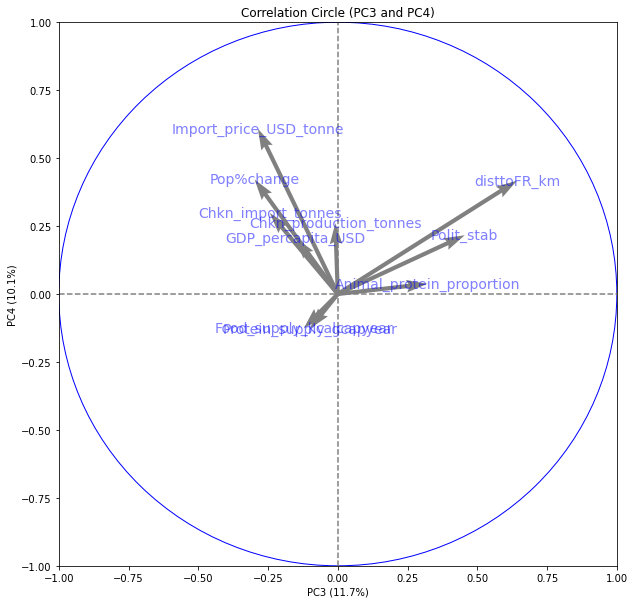

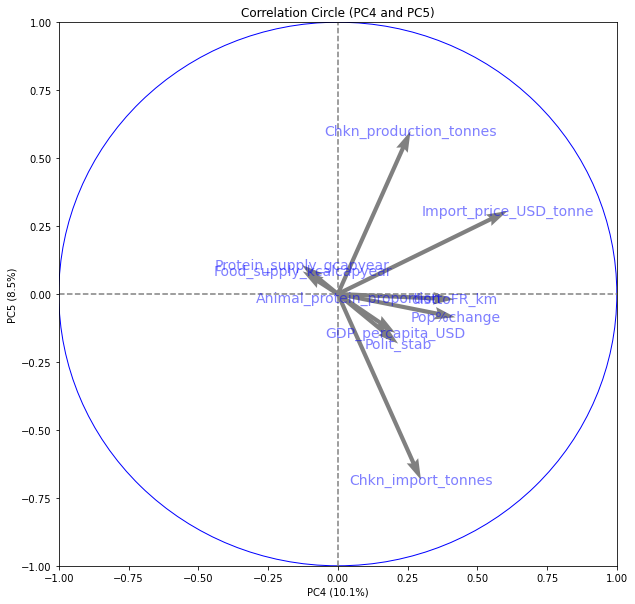

In [63]:
# correlation circle
pcs = pca.components_
display_circles(pcs, num_components, pca, [(0,1)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(1,2)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(2,3)], labels=np.array(X.columns))
display_circles(pcs, num_components, pca, [(3,4)], labels=np.array(X.columns))

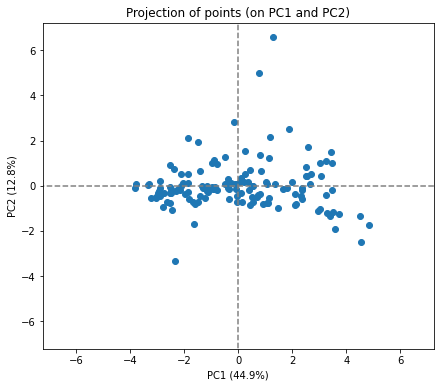

In [64]:
# individuals factor map

# transform original scaled data to the new vector space
X_projected = pca.transform(X_scaled)

# display scatter plot for this new vectSpace
display_factorial_planes(X_projected, num_components, pca, [(0,1)])
plt.show();

In [65]:
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered['cluster'] = clusters

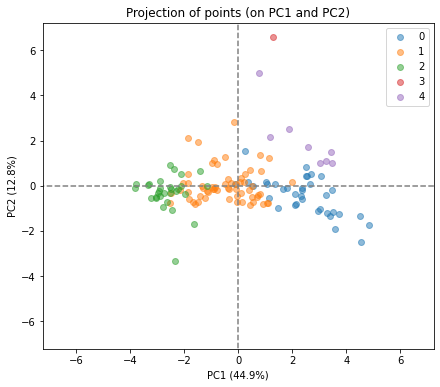

In [66]:
# all clusters on 1st factorial plane
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, num_components, pca, [(0,1)], illustrative_var = clusters, alpha = 0.5)

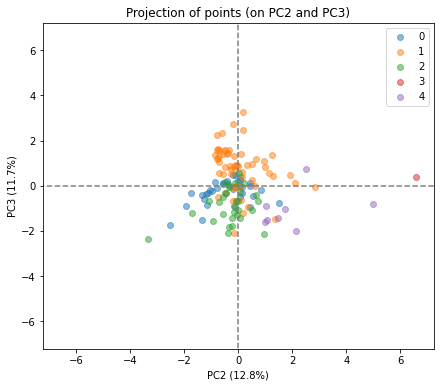

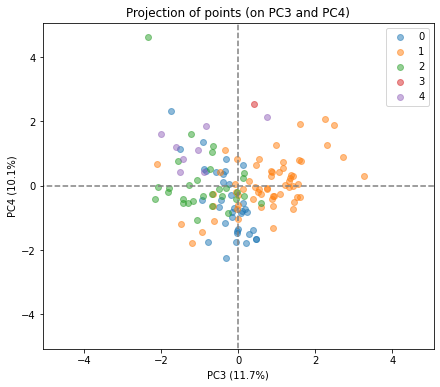

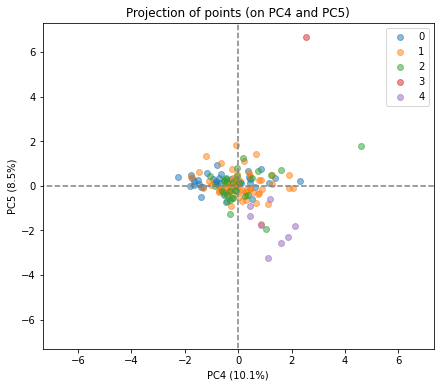

In [67]:
# individual factor maps

X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, num_components, pca, 
                         [(1,2),(2,3),(3,4)], illustrative_var = clusters, alpha = 0.5)

## K-means v2

In [68]:
# get data
X = df.copy()

# standardizing the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# Kmeans clustering model
kmeans = KMeans(init='random', n_clusters=5, n_init=20)

# fit data to the model
kmeans.fit(X_scaled)

# trace each datapoint to its corresponding cluster
clusters = kmeans.predict(X_scaled)

# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

X_scaled_clustered['cluster'].value_counts()

4    44
3    42
2    27
1    17
0     6
Name: cluster, dtype: int64

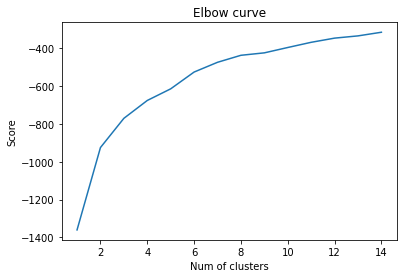

In [69]:
# Elbow method for cluster num approximation

num_clusters = 15
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans_tests))]

# plot the curve
plt.plot(range(1,num_clusters), score)
plt.xlabel('Num of clusters')
plt.ylabel('Score')
plt.title('Elbow curve')
plt.show();

In [70]:
# standardizing the data
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

# Kmeans clustering model
kmeans = KMeans(init='random', n_clusters=5, n_init=20)

# fit data to the model
kmeans.fit(X_scaled)

# trace each datapoint to its corresponding cluster
clusters = kmeans.predict(X_scaled)

# add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered['cluster'] = clusters

X_scaled_clustered['cluster'].value_counts()

3    39
0    35
2    33
1    28
4     1
Name: cluster, dtype: int64

In [71]:
# visualize clusters
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

X_reduced = pca.transform(X_scaled)

In [72]:
# convert into a dataframe
X_reduceddf = pd.DataFrame(X_reduced, index=X.index, columns=['PC1', 'PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

,PC1,PC2,cluster
Area,,,
Afghanistan,-3.78,0.07,3
Albania,1.80,-0.10,0
Angola,-2.38,0.73,3
Antigua and Barbuda,0.44,-0.87,2
Argentina,1.14,1.24,2


### visualize Centroids

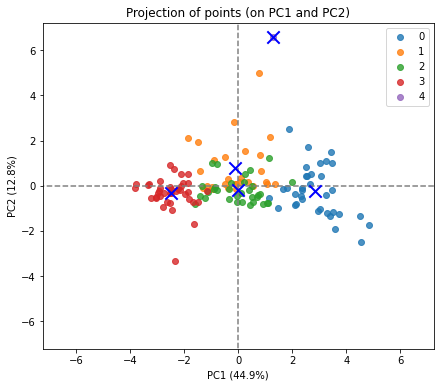

In [73]:
# visualize cluster centers
centres_reduced = pca.transform(kmeans.cluster_centers_)

display_factorial_planes(X_reduced, 2, pca, [(0,1)], illustrative_var = clusters, alpha=0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
           marker='x', s=152, linewidth=2, color='blue', zorder=10)

## clusters centers into csv

In [74]:
cluster_centers = pd.DataFrame(data=centres_reduced, columns=['PC1', 'PC2'], dtype=np.float64)
cluster_centers.index.name = 'cluster'
cluster_centers.to_csv('clusters_centers.csv')
cluster_centers

,PC1,PC2
cluster,,
0,2.84,-0.25
1,-0.14,0.77
2,-0.00,-0.20
3,-2.48,-0.33
4,1.27,6.57


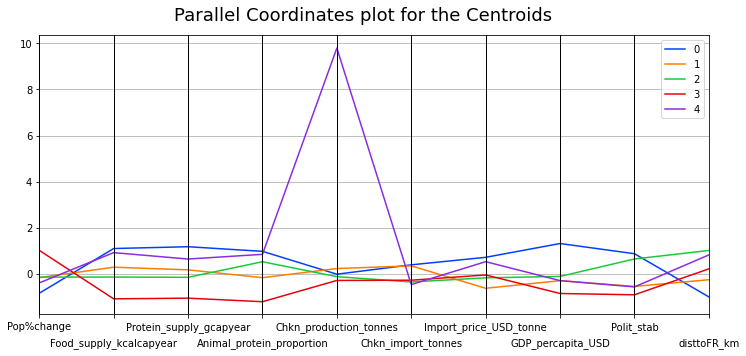

In [75]:
# interpreting meaning of clusters
X_clustered = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_clustered['cluster'] = clusters

# visualizing characteristics of each cluster by variable mean
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 5)

## Tests

Dans votre partition, vous avez obtenu des groupes distincts. Vérifiez donc qu'ils diffèrent réellement. Pour cela, réalisez les tests statistiques suivants :

    un test d'adéquation : parmi les 4 variables, ou parmi d'autres variables que vous trouverez pertinentes, trouvez une variable dont la loi est normale ;
    un test de comparaison de deux populations (dans le cas gaussien) : choisissez 2 clusters parmi ceux que vous aurez déterminé. Sur ces 2 clusters, testez la variable gaussienne grâce à un test de comparaison.

In your partition, you have obtained distinct groups. Check that they are really different. To do this, carry out the following statistical tests:

    a goodness-of-fit test: among the 4 variables, or among other variables that you find relevant, find a variable whose distribution is normal;
    a comparison test of two populations (in the Gaussian case): choose 2 clusters among those you have determined. On these 2 clusters, test the Gaussian variable using a comparison test.

In [76]:
df.head(1)

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km
Area,,,,,,,,,,
Afghanistan,12.31,"744,600.00","20,264.80",0.19,"28,493.00","23,913.00","1,344.03","2,065.00",-2.65,"5,596.67"


### Test d'adequation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html
ks_2samp(data1, data2, alternative='two-sided', mode='auto')
returns test stat and p-value

two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative.

critical values table
https://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/

The hypothesis regarding the distributional form is rejected if the test statistic, D, is greater than the critical value obtained from a table\
D < 0.84189 means we do NOT reject N0 at 5% confidence level\
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm

Null hypothesis: two distributions are identical\
Alt hypothesis: two distributions are NOT identical

In [77]:
# Kolmogorov-Smirnov (for continuous variable)

print(ks_2samp(df['Pop%change'],
         list(np.random.normal(np.mean(df['Pop%change']), np.std(df['Pop%change']), 1000))))

print(stats.shapiro(df['Pop%change']))

KstestResult(statistic=0.06452941176470588, pvalue=0.6743459824855422)
ShapiroResult(statistic=0.9894477128982544, pvalue=0.39202043414115906)


In [78]:
# KS statistic (D) lower than critical value from test table - we do not reject Null hypothesis (two distributions are identical)

In [79]:
print(ks_2samp(df['Protein_supply_gcapyear'],
         list(np.random.normal(np.mean(df['Protein_supply_gcapyear']), np.std(df['Protein_supply_gcapyear']), 1000))))

print(stats.shapiro(df['Protein_supply_gcapyear']))

KstestResult(statistic=0.07023529411764706, pvalue=0.5694988736580229)
ShapiroResult(statistic=0.9828914999961853, pvalue=0.08629298210144043)


In [80]:
# KS statistic (D) lower than critical value from test table - we do not reject Null hypothesis (two distributions are identical)

In [81]:
print(ks_2samp(df['Food_supply_kcalcapyear'],
         list(np.random.normal(np.mean(df['Food_supply_kcalcapyear']), np.std(df['Food_supply_kcalcapyear']), 1000))))

print(stats.shapiro(df['Food_supply_kcalcapyear']))

KstestResult(statistic=0.09070588235294118, pvalue=0.2606411983775233)
ShapiroResult(statistic=0.9873552918434143, pvalue=0.24760183691978455)


In [82]:
# KS statistic (D) lower than critical value from test table - we do not reject Null hypothesis (two distributions are identical)

In [83]:
print(ks_2samp(df['Animal_protein_proportion'],
         list(np.random.normal(np.mean(df['Animal_protein_proportion']), np.std(df['Animal_protein_proportion']), 1000))))

print(stats.shapiro(df['Animal_protein_proportion']))

KstestResult(statistic=0.08423529411764706, pvalue=0.34252884300495867)
ShapiroResult(statistic=0.949143648147583, pvalue=6.644404493272305e-05)


In [84]:
# KS statistic (D) lower than critical value from test table - we do not reject Null hypothesis (two distributions are identical)

In [85]:
print(ks_2samp(df['Import_price_USD_tonne'],
         list(np.random.normal(np.mean(df['Import_price_USD_tonne']), np.std(df['Import_price_USD_tonne']), 1000))))

print(stats.shapiro(df['Import_price_USD_tonne']))

KstestResult(statistic=0.12723529411764706, pvalue=0.03758853849407273)
ShapiroResult(statistic=0.8176114559173584, pvalue=1.0315153245454844e-11)


In [86]:
# KS statistic (D) lower than critical value from test table - we do not reject Null hypothesis (two distributions are identical)

In [87]:
print(ks_2samp(df['GDP_percapita_USD'],
         list(np.random.normal(np.mean(df['GDP_percapita_USD']), np.std(df['GDP_percapita_USD']), 1000))))

print(stats.shapiro(df['GDP_percapita_USD']))

KstestResult(statistic=0.1721764705882353, pvalue=0.0014164804773727502)
ShapiroResult(statistic=0.8418179750442505, pvalue=8.834812048608143e-11)


In [88]:
# KS statistic (D) lower than critical value from test table - we do not reject Null hypothesis (two distributions are identical)

### test de comparaison de deux populations (dans le cas gaussien)

In [89]:
display(cluster0.head(1))
display(cluster3.head(1))

,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km,cluster
Area,,,,,,,,,,,
Albania,-0.44,"1,226,400.00","42,245.10",0.54,"11,633.00","11,588.00","1,350.48","13,671.50",0.12,"1,606.18",0


,Pop%change,Food_supply_kcalcapyear,Protein_supply_gcapyear,Animal_protein_proportion,Chkn_production_tonnes,Chkn_import_tonnes,Import_price_USD_tonne,GDP_percapita_USD,Polit_stab,disttoFR_km,cluster
Area,,,,,,,,,,,
Brazil,3.88,"1,204,865.00","34,923.20",0.56,"13,516,525.00","3,396.00","2,267.99","14,763.90",-0.55,"8,706.47",3


In [90]:
cl0_pop = cluster0['Pop%change']
cl3_pop = cluster3['Pop%change']

cl0_price = cluster0['Import_price_USD_tonne']
cl3_price = cluster3['Import_price_USD_tonne']

In [91]:
# equality of variances
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html

scipy.stats.bartlett(cl0_pop, cl3_pop)

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\scipy\stats\morestats.py:2304: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1.0 + 1.0/(3*(k - 1)) * ((np.sum(1.0/(Ni - 1.0), axis=0)) -


BartlettResult(statistic=nan, pvalue=nan)

In [92]:
# pvalue = 0.77, we do not reject N0 (equality of variances) at 5% test confidence

In [93]:
# equality of means
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
scipy.stats.ttest_ind(cl0_pop, cl3_pop, equal_var=True)

C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\aciag\anaconda3\envs\ocda\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ttest_indResult(statistic=nan, pvalue=nan)

In [94]:
# pvalue = 0.18, we do not reject N0 (equality of means) at 5% test confidence

In [95]:
scipy.stats.bartlett(cl0_price, cl3_price)

BartlettResult(statistic=nan, pvalue=nan)

In [96]:
# pvalue = 0.88, we do not reject N0 (equality of variances) at 5% test confidence

In [97]:
scipy.stats.ttest_ind(cl0_price, cl3_price, equal_var=True)

Ttest_indResult(statistic=nan, pvalue=nan)

In [98]:
# pvalue = 0.58, we do not reject N0 (equality of variances) at 5% test confidence

# **Deliverables**

    The dendrogram in an image format (.png or .jpg).
    The Python or R code containing all the elements of the statement.
    A CSV file containing the list of countries and (for each of them) their group that you will have determined after cutting the dendrogram.
    A CSV file containing the centroids of the groups and their coordinates in each dimension.
    A presentation in the form of slides for the defense.

In [99]:
df_dist = pd.read_csv("C:/Users/aciag/Desktop/IDF OpenClassrooms/P5_Mykhailytskyi_Mykola/concap.csv")
df_dist = df_dist.rename(columns={'CountryName':'Area', 'CapitalLatitude':'lat', 'CapitalLongitude':'lon'})
df_dist = df_dist.set_index('Area')
df_dist = df_dist.drop(columns=['CapitalName', 'CountryCode', 'ContinentName'])
df_dist.head(3)

,lat,lon
Area,,
Somaliland,9.55,44.05
South Georgia and South Sandwich Islands,-54.28,-36.50
French Southern and Antarctic Lands,-49.35,70.22


In [100]:
fr1 = df_dist[df_dist.index == 'France'].loc[:, 'lat'][0]
fr2 = df_dist[df_dist.index == 'France'].loc[:, 'lon'][0]

In [101]:
for index, row in df_dist.iterrows():
    df_dist.loc[index, 'disttoFR_km'] = distance.distance((fr1, fr2), (row['lat'], row['lon'])).km

In [102]:
df_dist
# https://pythonguides.com/pandas-dataframe-iterrows/

,lat,lon,disttoFR_km
Area,,,
Somaliland,9.55,44.05,"5,829.52"
South Georgia and South Sandwich Islands,-54.28,-36.50,"11,997.82"
French Southern and Antarctic Lands,-49.35,70.22,"12,673.00"
Palestine,31.77,35.23,"3,339.10"
Aland Islands,60.12,19.90,"1,681.82"
...,...,...,...
Northern Cyprus,35.18,33.37,"2,955.33"
Hong Kong,0.00,0.00,"5,419.44"
Heard Island and McDonald Islands,0.00,0.00,"5,419.44"
